In [1]:
import numpy as np
import torch
from ADEN import ADEN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def d_t(x, y):
    return 0.5 * torch.norm(x - y) ** 2

In [3]:
N = 100 # number of samples
M = 10 # number of clusters
Batch_size = 16 # number of batches
num_samples_in_batch = 8 # number of samples in each batch
input_dim = 2 # dimensionality of the input space
X = torch.randn(N, input_dim).to(device)  # example input tensor (N, input_dim)
Y = torch.randn(M, input_dim).to(device)  # example cluster tensor (M, input_dim)
model = ADEN(input_dim=input_dim).to(device)


In [4]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
for epoch in range(1000):  # example training loop

    X_batches = torch.zeros(Batch_size, num_samples_in_batch, input_dim).to(device)  # (Batch_size, num_samples_in_batch, input_dim)
    for i in range(Batch_size):
        batch_indices = torch.randint(0, N, (num_samples_in_batch,)).to(device)
        X_batches[i] = X[batch_indices]
    Y_batches = Y.unsqueeze(0).expand(Batch_size, -1, -1).to(device)  # (Batch_size, M, input_dim)

    predicted_distances = model(X_batches, Y_batches) # predicted distances (Batch_size, num_samples_in_batch, M)
    idx = torch.argmin(predicted_distances, dim=-1).long()  # indices of the closest clusters (Batch_size, num_samples_in_batch)
    # create a mask of chosen indices to only include them in the training error
    mask = torch.zeros_like(predicted_distances, dtype=torch.bool)
    mask.scatter_(2, idx.unsqueeze(2), 1) # (Batch_size, num_samples_in_batch, M)
    gamma = 100.0
    transition_probs = torch.exp(-gamma *torch.cdist(Y,Y, p=2))  # (M, M)
    transition_probs = transition_probs / transition_probs.sum(dim=-1, keepdim=True)
    D = torch.zeros(Batch_size, num_samples_in_batch, M).to(device)  # (Batch_size, num_samples_in_batch)
    for i in range(Batch_size):
        for j in range(num_samples_in_batch):
            realized_cluster = torch.multinomial(transition_probs[idx[i][j]], 1).item()
            D[i][j][idx[i][j]] = d_t(X_batches[i][j], Y[realized_cluster])
    # take MSE error between D and predicted_distances only when mask is true
    mse_loss = torch.mean((D[mask] - predicted_distances[mask]) ** 2)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, MSE Loss: {mse_loss.item()}")
    optimizer.zero_grad()
    mse_loss.backward()
    optimizer.step()

Epoch 0, MSE Loss: 0.6702319383621216
Epoch 10, MSE Loss: 0.08894237130880356
Epoch 20, MSE Loss: 0.036242712289094925
Epoch 30, MSE Loss: 0.028159260749816895
Epoch 40, MSE Loss: 0.019356153905391693
Epoch 50, MSE Loss: 0.017400173470377922
Epoch 60, MSE Loss: 0.016980944201350212
Epoch 70, MSE Loss: 0.014911229722201824
Epoch 80, MSE Loss: 0.011664076708257198
Epoch 90, MSE Loss: 0.008228459395468235
Epoch 100, MSE Loss: 0.013489059172570705
Epoch 110, MSE Loss: 0.008950801566243172
Epoch 120, MSE Loss: 0.010774632915854454
Epoch 130, MSE Loss: 0.009594648145139217
Epoch 140, MSE Loss: 0.009208332747220993
Epoch 150, MSE Loss: 0.007350776810199022
Epoch 160, MSE Loss: 0.010120636783540249
Epoch 170, MSE Loss: 0.009460455738008022
Epoch 180, MSE Loss: 0.010207828134298325
Epoch 190, MSE Loss: 0.009393207728862762
Epoch 200, MSE Loss: 0.008516978472471237
Epoch 210, MSE Loss: 0.006531969644129276
Epoch 220, MSE Loss: 0.007553262636065483
Epoch 230, MSE Loss: 0.009346367791295052
Epoch 

In [5]:
y_to_be_optimized = Y.clone().detach().requires_grad_(True)  # make Y a parameter to be optimized
# fix model weights
for param in model.parameters():
    param.requires_grad = False


In [17]:
optimizer_y = torch.optim.AdamW([y_to_be_optimized], lr=1e-4, weight_decay=1e-5)

beta = 10
F_old = torch.tensor(float('inf'), device=device)  # Initialize F_old to a large value
while True:
    # Update y_to_be_optimized using the gradients
    d_s = torch.cdist(X, y_to_be_optimized, p=2) # (N, M)
    F = -1/beta*torch.sum(torch.log(torch.sum(torch.exp(-beta*d_s), dim=-1)))
    optimizer_y.zero_grad()
    F.backward()
    optimizer_y.step()
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, F: {F.item()}")
    if torch.norm(F_old - F)/torch.norm(F) < 1e-8:
        break
    F_old = F.clone()  # Update F_old for the next iteration

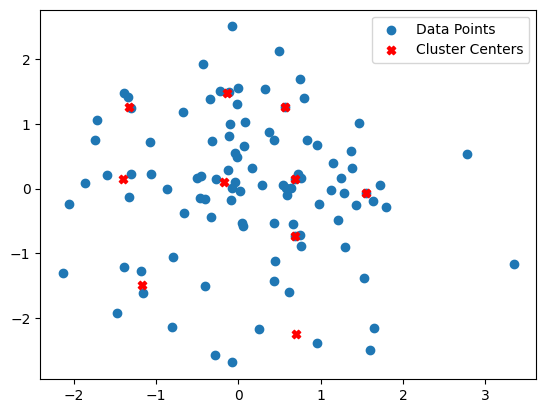

In [19]:
# plot locations of X and final y
import matplotlib.pyplot as plt
# converting results to numpy
X_np = X.detach().cpu().numpy()
y_np = y_to_be_optimized.detach().cpu().numpy()
plt.scatter(X_np[:, 0], X_np[:, 1], label='Data Points')
plt.scatter(y_np[:, 0], y_np[:, 1], label='Cluster Centers', marker='X', color='red')
plt.legend()
plt.show()